# Msg1 Attack on Network Access Model

## Common Code for Experiment 1A-1C Figures

In [1]:
# Cell 1 — Imports & config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (Optional) wider plots
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Cell 2 — Load CSV
CSV_PATH = "../dataset/expe01.csv"

df = pd.read_csv(CSV_PATH)

# Basic sanity
assert {"id","variable","Ta","beta","delta","j","p_threshold","p_s"} <= set(df.columns), "CSV columns mismatch"

# Make sure numeric columns are numeric
for col in ["Ta","beta","delta","j","p_threshold","p_s"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

display(df.head())

,id,variable,Ta,beta,delta,j,p_threshold,p_s
0,1,Ta,1,0.12,12,0,17.100000,1.0
1,2,Ta,1,0.12,12,1,21.266667,1.0
2,3,Ta,1,0.12,12,2,24.800000,1.0
3,4,Ta,1,0.12,12,3,27.766667,1.0
4,5,Ta,1,0.12,12,4,30.466667,1.0


In [3]:
# Cell 3 — Core model (single Ta, single β)
def compute_p_success(P_noise, P_attacker, P_UE, beta, delta, Ta, j_max):
    """
    Deterministic model:
      P_th(0) = P_noise
      P_th(i+1) = (1 - beta)*P_th(i) + beta*P_attacker, when (i) % Ta == 0 and i > 0
                  (1 - beta)*P_th(i) + beta*P_noise,    otherwise
      P_S(j) = 1 if P_UE > (P_th(j) + delta) else 0
    Returns:
      j_range: 0..j_max
      P_S: length j_max+1 (0/1)
      P_th: length j_max+1
    """
    j_range = np.arange(0, j_max + 1)
    P_th = [P_noise]  # P_th at j=0

    for i in range(1, j_max + 1):
        if (i - 1) % Ta == 0 and i > 0:
            P_next = (1 - beta) * P_th[-1] + beta * P_attacker
        else:
            P_next = (1 - beta) * P_th[-1] + beta * P_noise
        P_th.append(P_next)

    P_S = [1 if P_UE > (P_th[j] + delta) else 0 for j in j_range]
    return j_range, P_S, P_th

In [4]:
# Cell 4 — Helper to extract experimental series from CSV

def experimental_series_from_csv(df, variable_key):
    """
    variable_key: 'Ta' or 'beta' or 'delta'
    Returns:
      frames (sorted unique j),
      exp_p_th: dict[var] -> list of p_threshold (NaNs kept, matplotlib skips),
      exp_p_s:  dict[var] -> list of p_s
    """
    sub = df[df["variable"] == variable_key].copy()
    # ensure per-var groups are ordered by j
    sub = sub.sort_values(["Ta","beta","delta","j"])
    exp_p_th = {}
    exp_p_s = {}
    if variable_key == "Ta":
        for Ta, g in sub.groupby("Ta"):
            exp_p_th[int(Ta)] = g["p_threshold"].tolist()
            exp_p_s[int(Ta)]  = g["p_s"].tolist()
    elif variable_key == "beta":
        for b, g in sub.groupby("beta"):
            exp_p_th[float(b)] = g["p_threshold"].tolist()
            exp_p_s[float(b)]  = g["p_s"].tolist()
    elif variable_key == "delta":
        for d, g in sub.groupby("delta"):
            exp_p_th[float(d)] = g["p_threshold"].tolist()
            exp_p_s[float(d)]  = g["p_s"].tolist()
    frames = np.sort(sub["j"].unique())
    return frames, exp_p_th, exp_p_s


## Experiment 1A: Varying Attacker Period $T_a$

In [5]:
# Cell 5 — Helpers to run sweep over Ta

def sweep_over_Ta(P_noise, P_attacker, P_UE, beta, delta, Ta_values, j_max):
    math_P_S = {}
    math_P_th = {}
    for Ta in Ta_values:
        j_range, P_S, P_th = compute_p_success(P_noise, P_attacker, P_UE, beta, delta, int(Ta), j_max)
        math_P_S[int(Ta)] = P_S
        math_P_th[int(Ta)] = P_th
    return j_range, math_P_S, math_P_th

In [6]:
# Cell 6 — Figure A (Ta sweep): set parameters and run model

# Parameters for this figure (based on your example)
P_noise_A     = 17.1   # baseline threshold at j=0
P_attacker_A  = 51.0
P_UE_A        = 56.4
beta_A        = 0.12   # noise update factor
delta_A       = 12.0
j_max_A       = 15

# Ta values (use what's present in CSV under variable=='Ta')
frames_A, exp_p_th_A, exp_p_s_A = experimental_series_from_csv(df, "Ta")
Ta_values_A = sorted(exp_p_th_A.keys())  # e.g., [1,2,16]

j_range_A, math_P_S_A, math_P_th_A = sweep_over_Ta(
    P_noise=P_noise_A, P_attacker=P_attacker_A, P_UE=P_UE_A,
    beta=beta_A, delta=delta_A, Ta_values=Ta_values_A, j_max=j_max_A
)

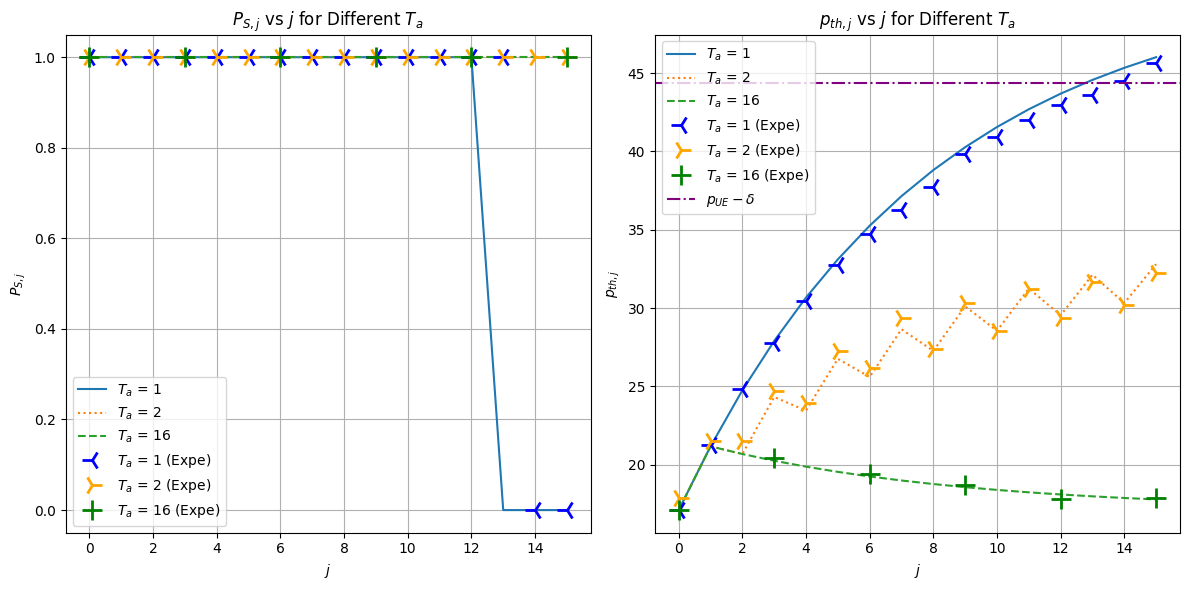

In [7]:
# Cell 7 — Plot Figure A (Ta sweep)
plt.figure(figsize=(12,6))

# Left: P_S vs j
plt.subplot(1,2,1)
for Ta, P_S in math_P_S_A.items():
    if Ta == 1:
        plt.plot(j_range_A, P_S, linestyle="solid", label=f"$T_a$ = {Ta}")
    elif Ta == 2:
        plt.plot(j_range_A, P_S, linestyle="dotted", label=f"$T_a$ = {Ta}")
    elif Ta == 16:
        plt.plot(j_range_A, P_S, linestyle="dashed", label=f"$T_a$ = {Ta}")

for Ta, ex in exp_p_s_A.items():
    if Ta == 1:
        plt.plot(frames_A, ex, linestyle="none", color="blue", marker="3",
                 markersize=15, markeredgewidth=2, label=f"$T_a$ = {Ta} (Expe)")
    elif Ta == 2:
        plt.plot(frames_A, ex, linestyle="none", color="orange", marker="4",
                 markersize=15, markeredgewidth=2, label=f"$T_a$ = {Ta} (Expe)")
    elif Ta == 16:
        plt.plot(frames_A, ex, linestyle="none", color="green", marker="+",
                 markersize=15, markeredgewidth=2, label=f"$T_a$ = {Ta} (Expe)")

plt.xlabel("$j$")
plt.xticks(np.arange(0, j_max_A+1, 2))
plt.ylabel("$P_{S,j}$")
plt.title("$P_{S,j}$ vs $j$ for Different $T_a$")
plt.legend()
plt.grid()

# Right: p_threshold vs j
plt.subplot(1,2,2)
for Ta, P_th in math_P_th_A.items():
    if Ta == 1:
        plt.plot(j_range_A, P_th, linestyle="solid", label=f"$T_a$ = {Ta}")
    elif Ta == 2:
        plt.plot(j_range_A, P_th, linestyle="dotted", label=f"$T_a$ = {Ta}")
    elif Ta == 16:
        plt.plot(j_range_A, P_th, linestyle="dashed", label=f"$T_a$ = {Ta}")

for Ta, ex in exp_p_th_A.items():
    if Ta == 1:
        plt.plot(frames_A, ex, linestyle="none", color="blue", marker="3",
                 markersize=15, markeredgewidth=2, label=f"$T_a$ = {Ta} (Expe)")
    elif Ta == 2:
        plt.plot(frames_A, ex, linestyle="none", color="orange", marker="4",
                 markersize=15, markeredgewidth=2, label=f"$T_a$ = {Ta} (Expe)")
    elif Ta == 16:
        plt.plot(frames_A, ex, linestyle="none", color="green", marker="+",
                 markersize=15, markeredgewidth=2, label=f"$T_a$ = {Ta} (Expe)")

plt.axhline(P_UE_A - delta_A, color="purple", ls="dashdot", label="$p_{UE} - \\delta$")
plt.xlabel("$j$")
plt.xticks(np.arange(0, j_max_A+1, 2))
plt.ylabel("$p_{th,j}$")
plt.title("$p_{th,j}$ vs $j$ for Different $T_a$")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Experiment 1B: Varying Noise Update Factor $\beta$

In [8]:
# Cell 8 — Helpers to run sweep over beta

def sweep_over_beta(P_noise, P_attacker, P_UE, beta_values, delta, Ta, j_max):
    math_P_S = {}
    math_P_th = {}
    for b in beta_values:
        j_range, P_S, P_th = compute_p_success(P_noise, P_attacker, P_UE, b, delta, Ta, j_max)
        math_P_S[float(b)] = P_S
        math_P_th[float(b)] = P_th
    return j_range, math_P_S, math_P_th

In [9]:
# Cell 9 — Figure B (β sweep): set parameters and run model

# Parameters for this figure (based on your example)
P_noise_B     = 16.88
P_attacker_B  = 51.0
P_UE_B        = 56.4
delta_B       = 12.0
Ta_B          = 1
j_max_B       = 15

# β values from CSV under variable=='beta'
frames_B, exp_p_th_B, exp_p_s_B = experimental_series_from_csv(df, "beta")
beta_values_B = sorted(exp_p_th_B.keys())  # e.g., [0.0, 0.06, 0.12, 0.24]

j_range_B, math_P_S_B, math_P_th_B = sweep_over_beta(
    P_noise=P_noise_B, P_attacker=P_attacker_B, P_UE=P_UE_B,
    beta_values=beta_values_B, delta=delta_B, Ta=Ta_B, j_max=j_max_B
)

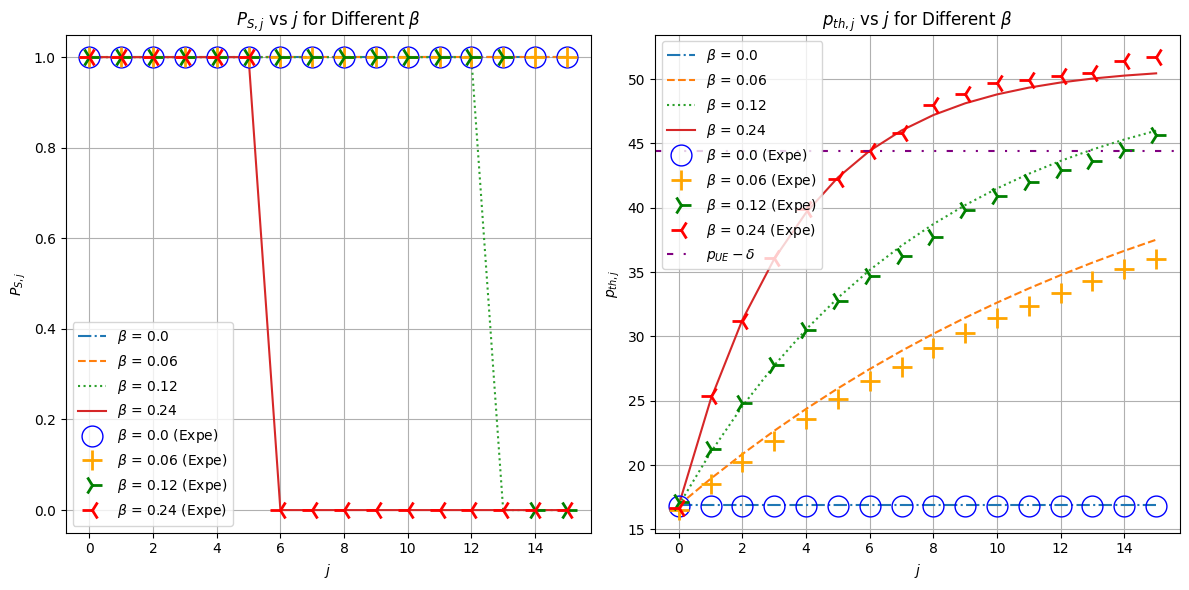

In [10]:
# Cell 10 — Plot Figure B (β sweep)
plt.figure(figsize=(12,6))

# Left: P_S vs j
plt.subplot(1,2,1)
for b, P_S in math_P_S_B.items():
    if b == 0.24:
        plt.plot(j_range_B, P_S, linestyle="solid", label=f"$\\beta$ = {b}")
    elif b == 0.12:
        plt.plot(j_range_B, P_S, linestyle="dotted", label=f"$\\beta$ = {b}")
    elif b == 0.06:
        plt.plot(j_range_B, P_S, linestyle="dashed", label=f"$\\beta$ = {b}")
    elif b == 0.0:
        plt.plot(j_range_B, P_S, linestyle="dashdot", label=f"$\\beta$ = {b}")

for b, ex in exp_p_s_B.items():
    if b == 0.24:
        plt.plot(frames_B, ex, linestyle="none", color="red", marker="3",
                 markersize=15, markeredgewidth=2, label=f"$\\beta$ = {b} (Expe)")
    elif b == 0.12:
        plt.plot(frames_B, ex, linestyle="none", color="green", marker="4",
                 markersize=15, markeredgewidth=2, label=f"$\\beta$ = {b} (Expe)")
    elif b == 0.06:
        plt.plot(frames_B, ex, linestyle="none", color="orange", marker="+",
                 markersize=15, markeredgewidth=2, label=f"$\\beta$ = {b} (Expe)")
    elif b == 0.0:
        plt.plot(frames_B, ex, linestyle="none", color="blue", marker="o",
                 markersize=15, markeredgewidth=1, fillstyle="none", label=f"$\\beta$ = {b} (Expe)")

plt.xlabel("$j$")
plt.xticks(np.arange(0, j_max_B+1, 2))
plt.ylabel("$P_{S,j}$")
plt.title("$P_{S,j}$ vs $j$ for Different $\\beta$")
plt.legend()
plt.grid()

# Right: p_threshold vs j
plt.subplot(1,2,2)
for b, P_th in math_P_th_B.items():
    if b == 0.24:
        plt.plot(j_range_B, P_th, linestyle="solid", label=f"$\\beta$ = {b}")
    elif b == 0.12:
        plt.plot(j_range_B, P_th, linestyle="dotted", label=f"$\\beta$ = {b}")
    elif b == 0.06:
        plt.plot(j_range_B, P_th, linestyle="dashed", label=f"$\\beta$ = {b}")
    elif b == 0.0:
        plt.plot(j_range_B, P_th, linestyle="dashdot", label=f"$\\beta$ = {b}")

for b, ex in exp_p_th_B.items():
    if b == 0.24:
        plt.plot(frames_B, ex, linestyle="none", color="red", marker="3",
                 markersize=15, markeredgewidth=2, label=f"$\\beta$ = {b} (Expe)")
    elif b == 0.12:
        plt.plot(frames_B, ex, linestyle="none", color="green", marker="4",
                 markersize=15, markeredgewidth=2, label=f"$\\beta$ = {b} (Expe)")
    elif b == 0.06:
        plt.plot(frames_B, ex, linestyle="none", color="orange", marker="+",
                 markersize=15, markeredgewidth=2, label=f"$\\beta$ = {b} (Expe)")
    elif b == 0.0:
        plt.plot(frames_B, ex, linestyle="none", color="blue", marker="o",
                 markersize=15, markeredgewidth=1, fillstyle="none", label=f"$\\beta$ = {b} (Expe)")

plt.axhline((P_UE_B - delta_B), color="purple", ls=(0, (3, 5, 1, 5, 1, 5)), label="$p_{UE} - \\delta$")
plt.xlabel("$j$")
plt.xticks(np.arange(0, j_max_B+1, 2))
plt.ylabel("$p_{th,j}$")
plt.title("$p_{th,j}$ vs $j$ for Different $\\beta$")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## Experiment 1C: Varying Msg1 Detection Margin $\delta$

In [11]:
# Cell 11 — Helpers to run sweep over delta

def sweep_over_delta(P_noise, P_attacker, P_UE, beta, delta_values, Ta, j_max):
    math_P_S = {}
    math_P_th = {}
    for d in delta_values:
        j_range, P_S, P_th = compute_p_success(P_noise, P_attacker, P_UE, beta, d, Ta, j_max)
        math_P_S[int(d)] = P_S
        math_P_th[int(d)] = P_th
    return j_range, math_P_S, math_P_th


In [12]:
# Cell 12 — Figure C (delta sweep): set parameters and run model

# Parameters for this figure (based on your example)
P_noise_D     = 17
P_attacker_D  = 51.0
P_UE_D        = 56.4
beta_D       = 0.12
Ta_D          = 1
j_max_D       = 15

# delta values from CSV under variable=='delta'
frames_D, exp_p_th_D, exp_p_s_D = experimental_series_from_csv(df, "delta")
delta_values_D = sorted(exp_p_th_D.keys())  # e.g., [24, 12, 6]

j_range_D, math_P_S_D, math_P_th_D = sweep_over_delta(
    P_noise=P_noise_D, P_attacker=P_attacker_D, P_UE=P_UE_D,
    delta_values=delta_values_D, beta=beta_D, Ta=Ta_D, j_max=j_max_D
)


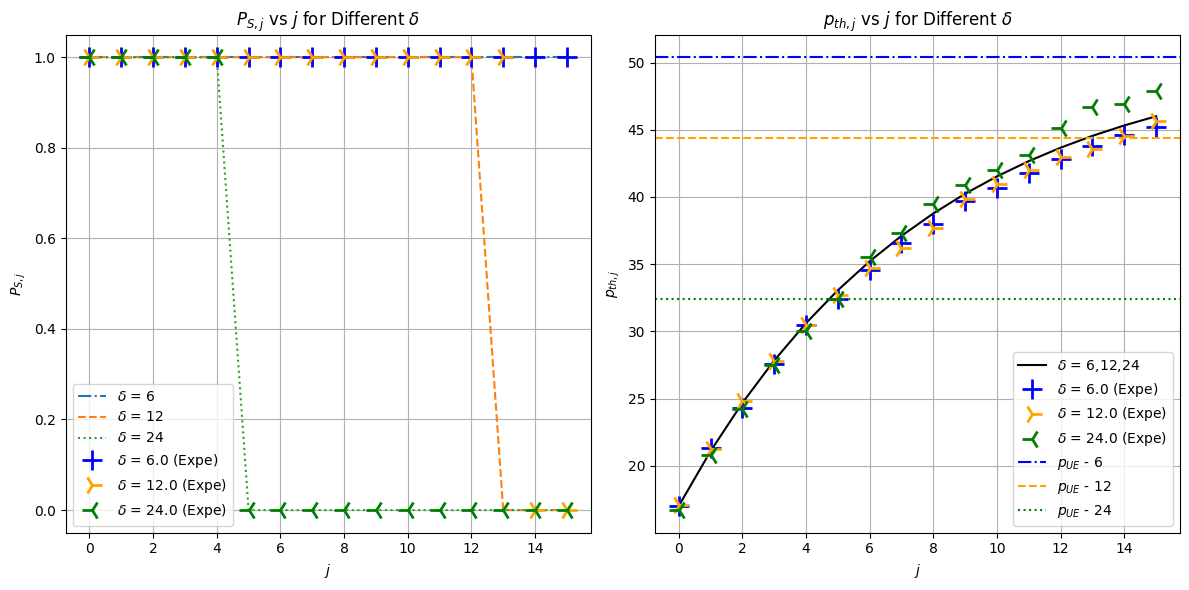

In [13]:
# Cell 13 — Plot Figure C (delta sweep)
plt.figure(figsize=(12,6))

# Left: P_S vs j
plt.subplot(1,2,1)
for d, P_S in math_P_S_D.items():
    if d == 24:
        plt.plot(j_range_D, P_S, linestyle="dotted", label=f"$\\delta$ = {d}")
    elif d == 12:
        plt.plot(j_range_D, P_S, linestyle="dashed", label=f"$\\delta$ = {d}")
    elif d == 6:
        plt.plot(j_range_D, P_S, linestyle="dashdot", label=f"$\\delta$ = {d}")

for d, ex in exp_p_s_D.items():
    if d == 24:
        plt.plot(frames_D, ex, linestyle="none", color="green", marker="3",
                 markersize=15, markeredgewidth=2, label=f"$\\delta$ = {d} (Expe)")
    elif d == 12:
        plt.plot(frames_D, ex, linestyle="none", color="orange", marker="4",
                 markersize=15, markeredgewidth=2, label=f"$\\delta$ = {d} (Expe)")
    elif d == 6:
        plt.plot(frames_D, ex, linestyle="none", color="blue", marker="+",
                 markersize=15, markeredgewidth=2, label=f"$\\delta$ = {d} (Expe)")
    # δ=0 is omitted in ORIGINAL

plt.xlabel("$j$")
plt.ylabel("$P_{S,j}$")
plt.xticks(np.arange(0, j_max_D+1, 2))
plt.title("$P_{S,j}$ vs $j$ for Different $\\delta$")
plt.legend()
plt.grid()

# Right: p_threshold vs j
plt.subplot(1,2,2)
for d, P_th in math_P_th_D.items():
    if d == 24:
        plt.plot(j_range_D, P_th, linestyle="solid", color="black", label=f"$\\delta$ = 6,12,24")

for d, ex in exp_p_th_D.items():
    if d == 24:
        plt.plot(frames_D, ex, linestyle="none", color="green", marker="3",
                 markersize=15, markeredgewidth=2, label=f"$\\delta$ = {d} (Expe)")
    elif d == 12:
        plt.plot(frames_D, ex, linestyle="none", color="orange", marker="4",
                 markersize=15, markeredgewidth=2, label=f"$\\delta$ = {d} (Expe)")
    elif d == 6:
        plt.plot(frames_D, ex, linestyle="none", color="blue", marker="+",
                 markersize=15, markeredgewidth=2, label=f"$\\delta$ = {d} (Expe)")

# Horizontal reference lines
plt.axhline(P_UE_D - 6, color="blue", ls="dashdot", label="$p_{UE}$ - 6")
plt.axhline(P_UE_D - 12, color="orange", ls="dashed", label="$p_{UE}$ - 12")
plt.axhline(P_UE_D - 24, color="green", ls="dotted", label="$p_{UE}$ - 24")
# δ=0 line is commented out in ORIGINAL

plt.xlabel("$j$")
plt.ylabel("$p_{th,j}$")
plt.xticks(np.arange(0, j_max_D+1, 2))
plt.title("$p_{th,j}$ vs $j$ for Different $\\delta$")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


## Experiment 1D: Experiment on srsRAN (Extra)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
CSV_PATH = "../dataset/expe01_srsran.csv"
df = pd.read_csv(CSV_PATH)

# Extract columns
p_attacker = df["p_attacker"].values
p_ue = df["p_ue"].values
p_threshold = df["p_threshold"].values
delta = df["delta"].values
p_s_exp = df["p_s"].values

# Calculate UE power - threshold (constant offset reference)
valid_mask = ~np.isnan(p_ue) & ~np.isnan(p_threshold)
if np.any(valid_mask):
    ue_minus_threshold = np.mean(p_ue[valid_mask] - delta[valid_mask])
else:
    ue_minus_threshold = np.nan

# Noise model: noise = attacker power
noise_model = p_attacker.copy()

# Probability model
prob_model = []
for i in range(len(p_attacker)):
    if not np.isnan(p_ue[i]):
        total_noise = noise_model[i] + delta[i]
        prob = 1 if p_ue[i] > total_noise else 0
    else:
        prob = np.nan
    prob_model.append(prob)
prob_model = np.array(prob_model)


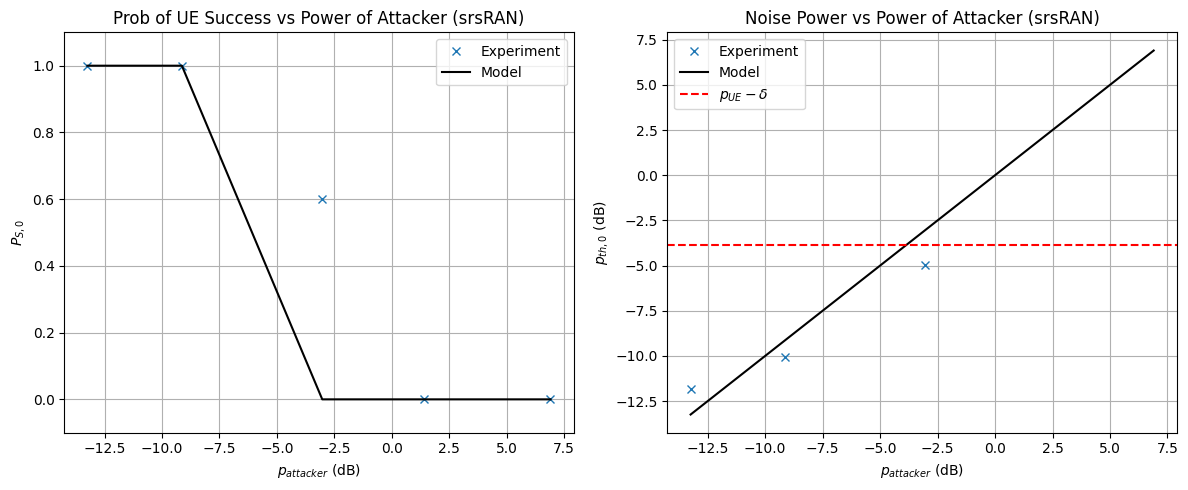

In [15]:
# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left Plot: UE Success Probability
axs[0].plot(p_attacker, p_s_exp, 'x', label='Experiment')
axs[0].plot(p_attacker, prob_model, 'k-', label='Model')
axs[0].set_title('Prob of UE Success vs Power of Attacker (srsRAN)')
axs[0].set_xlabel('$p_{attacker}$ (dB)')
axs[0].set_ylabel('$P_{S,0}$')
axs[0].set_ylim(-0.1, 1.1)
axs[0].grid(True)
axs[0].legend()

# Right Plot: Noise Power
axs[1].plot(p_attacker, p_threshold, 'x', label='Experiment')
axs[1].plot(p_attacker, noise_model, 'k-', label='Model')
axs[1].set_title('Noise Power vs Power of Attacker (srsRAN)')
axs[1].set_xlabel('$p_{attacker}$ (dB)')
axs[1].set_ylabel('$p_{th,0}$ (dB)')
axs[1].axhline(y=ue_minus_threshold, color='r', linestyle='--', label='$p_{UE} - \delta$')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


# Msg3 Attack on Network Access Model

## Common Code for All Experiment 2 Figures

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Experimental Dataset ---
CSV_PATH = "../dataset/expe02.csv"
df = pd.read_csv(CSV_PATH)
df.head()


,id,variable,d_ue,p_rxue,d_attacker,p_rxattacker,p_s
0,1,d_ue,90.3,NaN,40.0,69.00,0.0
1,2,d_ue,90.3,NaN,56.5,63.34,0.0
2,3,d_ue,90.3,NaN,89.4,58.98,0.0
3,4,d_ue,90.3,NaN,126.4,59.22,0.0
4,5,d_ue,90.3,NaN,164.9,53.74,0.0


In [17]:
# --- Model Functions ---
alpha = 5
d_attacker_values = np.linspace(1, 450, 449)  # attacker distance in cm

def calculate_P_attacker_dB(d_attacker, P_attacker_TX_dB, gamma):
    return P_attacker_TX_dB - 10 * gamma * np.log10(d_attacker)

def calculate_P_S(P_attacker_dB, P_UE_dB, alpha):
    return 1 / (1 + np.exp(alpha * (P_attacker_dB - P_UE_dB)))

## Experiment 2A: Varying UE and Attacker Distance to gNB

In [18]:
# --- Experiment 2A: Varying UE and Attacker Distance to gNB ---

df_2A = df[df['variable'] == 'd_ue']
grouped_2A = df_2A.groupby('d_ue')

# Experimental data container
data_2A = []

# Attacker distance range in cm
d_attacker_values = np.linspace(1, 450, 449)

# Fixed model parameters (single model curve for all UE distances)
P_UE_dB = 50
P_attacker_TX_dB = 97.5
gamma = 1.92

# Model curves (only once, not per UE distance)
P_attacker_dB_model = calculate_P_attacker_dB(d_attacker_values, P_attacker_TX_dB, gamma)
P_S_model = calculate_P_S(P_attacker_dB_model, P_UE_dB, alpha)

for d_ue, group in grouped_2A:
    group = group.reset_index()
    data_2A.append({
        'd_ue': d_ue,
        'd_att': group['d_attacker'].values,
        'p_att': group['p_rxattacker'].values,
        'p_s': group['p_s'].values
    })


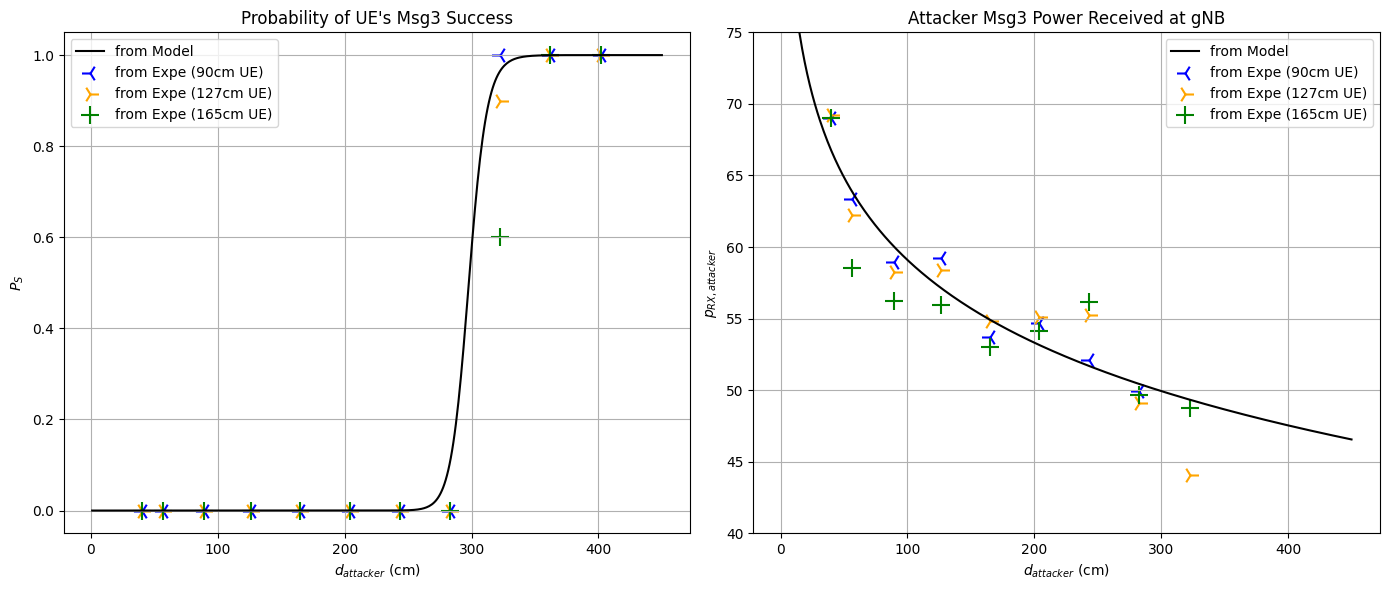

In [19]:
# --- Plot Experiment 2A ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = ['blue', 'orange', 'green']
markers = ['3', '4', '+']

# Left: Probability of success
ax1.plot(d_attacker_values, P_S_model, color='black', label='from Model')
for idx, data in enumerate(data_2A):
    ax1.scatter(data['d_att'], data['p_s'], marker=markers[idx], s=150,
                color=colors[idx], label=f"from Expe ({data['d_ue']:.0f}cm UE)")
ax1.set_title("Probability of UE's Msg3 Success")
ax1.set_xlabel("$d_{attacker}$ (cm)")
ax1.set_ylabel("$P_S$")
ax1.grid(True)
ax1.legend()

# Right: Attacker Msg3 Power
ax2.plot(d_attacker_values, P_attacker_dB_model, color='black', label='from Model')
for idx, data in enumerate(data_2A):
    ax2.scatter(data['d_att'], data['p_att'], marker=markers[idx], s=150,
                color=colors[idx], label=f"from Expe ({data['d_ue']:.0f}cm UE)")
ax2.set_title("Attacker Msg3 Power Received at gNB")
ax2.set_xlabel("$d_{attacker}$ (cm)")
ax2.set_ylabel("$p_{RX,attacker}$")
ax2.set_ylim(40, 75)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


## Experiment 2B: Varying UE Msg3 Target Power and Attacker Distance

In [20]:
# --- Experiment 2B: Varying UE Msg3 Target Power and Attacker Distance ---

# Filter dataset
df_2B = df[df['variable'] == 'p_rxue']

# Model parameters from ORI
P_UE_dB_values = [49.3, 51.4, 60.4]
P_attacker_TX_dB_values = [101.46, 100.91, 95.76]
gamma_values = [2.11, 2.09, 1.75]
alpha = 5
d_attacker_values = np.linspace(1, 450, 449)

# Precompute model curves
P_attacker_dB_models = [
    calculate_P_attacker_dB(d_attacker_values, P_attacker_TX_dB, gamma)
    for P_attacker_TX_dB, gamma in zip(P_attacker_TX_dB_values, gamma_values)
]
P_S_models = [
    calculate_P_S(P_attacker_dB, P_UE_dB, alpha)
    for P_attacker_dB, P_UE_dB in zip(P_attacker_dB_models, P_UE_dB_values)
]

# Group experimental data
grouped_2B = df_2B.groupby('p_rxue')
data_2B = []
for p_rxue, group in grouped_2B:
    group = group.reset_index()
    data_2B.append({
        'p_rxue': p_rxue,
        'd_att': group['d_attacker'].values,
        'p_att': group['p_rxattacker'].values,
        'p_s': group['p_s'].values
    })


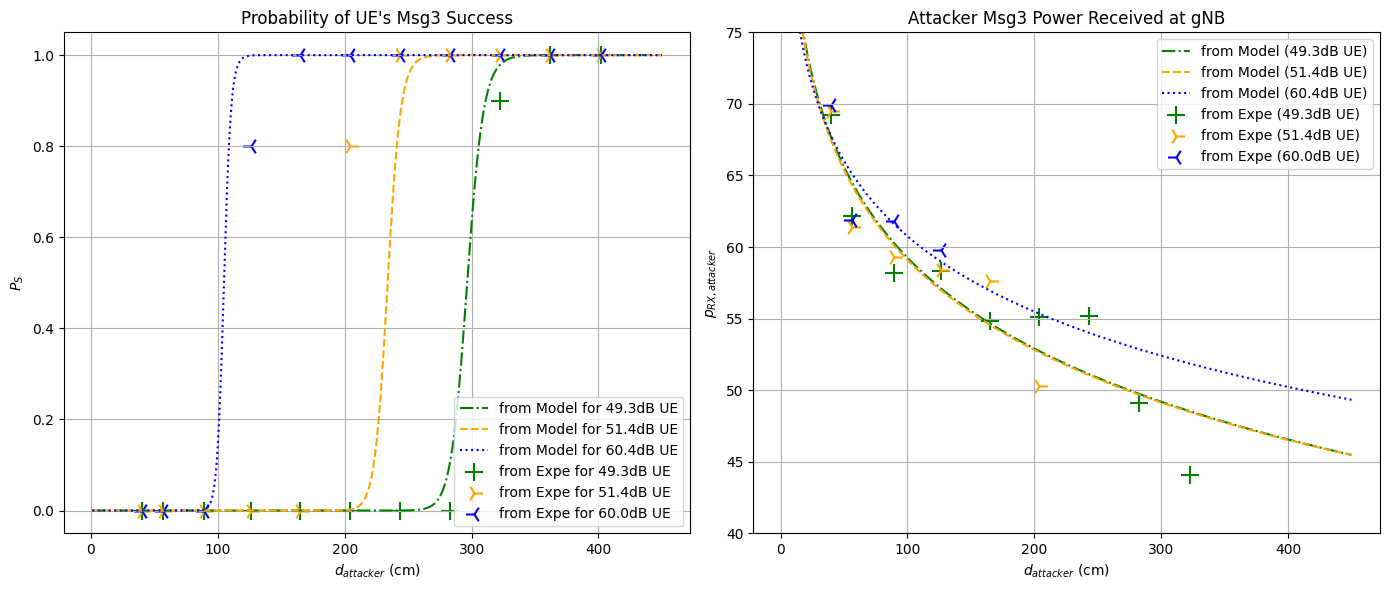

In [21]:
# --- Plot Experiment 2B ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

colors = ['green', 'orange', 'blue']     # 49, 51, 60
linestyles = ['dashdot', 'dashed', 'dotted']
markers = ['+', '4', '3']

# Left: Probability of success
for i, (p_ue, P_S_model) in enumerate(zip(P_UE_dB_values, P_S_models)):
    ax1.plot(d_attacker_values, P_S_model, color=colors[i], linestyle=linestyles[i],
             label=f'from Model for {p_ue:.1f}dB UE')
for i, data in enumerate(data_2B):
    ax1.scatter(data['d_att'], data['p_s'], color=colors[i], marker=markers[i], s=150,
                label=f'from Expe for {data["p_rxue"]:.1f}dB UE')

ax1.set_title("Probability of UE's Msg3 Success")
ax1.set_xlabel("$d_{attacker}$ (cm)")
ax1.set_ylabel("$P_S$")
ax1.grid(True)
ax1.legend()

# Right: Attacker Msg3 Power
for i, P_attacker_dB in enumerate(P_attacker_dB_models):
    ax2.plot(d_attacker_values, P_attacker_dB, color=colors[i], linestyle=linestyles[i],
             label=f'from Model ({P_UE_dB_values[i]:.1f}dB UE)')
for i, data in enumerate(data_2B):
    ax2.scatter(data['d_att'], data['p_att'], color=colors[i], marker=markers[i], s=150,
                label=f'from Expe ({data["p_rxue"]:.1f}dB UE)')

ax2.set_title("Attacker Msg3 Power Received at gNB")
ax2.set_xlabel("$d_{attacker}$ (cm)")
ax2.set_ylabel("$p_{RX,attacker}$")
ax2.set_ylim(40, 75)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


#  Msg1 Attack on NES

In [22]:
# --- Load Experiment 3 Data ---
CSV_PATH = "../dataset/expe03.csv"
df_3 = pd.read_csv(CSV_PATH)

# Split normal and attack profiles
normal_profile = df_3[df_3["variable"] == "normal"]
attack_profile = df_3[df_3["variable"] == "attack"]

t1 = normal_profile["time"].values
p1_exp = normal_profile["power"].values

t2 = attack_profile["time"].values
p2_exp = attack_profile["power"].values

# --- Model Profiles (same parameters as ORIGINAL) ---
trans_down = 1
trans_up = 6
stay_active = 17
total_cycle = trans_down*2 + trans_up*2 + stay_active
p_idle = 28
p_sleep = 51
p_active = 72

# Time resolution
dt = 1

# Normal profile: constant sleep power
t1_model = np.arange(0, total_cycle, dt)
p1_model = np.full_like(t1_model, p_sleep)

# Attacked profile segments
t2_1 = np.arange(0, trans_down, dt)
p2_1 = np.linspace(p_sleep, p_idle, len(t2_1))

t2_2 = np.arange(0, trans_up, dt)
p2_2 = np.linspace(p_idle, p_active, len(t2_2))

t2_3 = np.arange(0, stay_active, dt)
p2_3 = np.full_like(t2_3, p_active)

t2_4 = np.arange(0, trans_down, dt)
p2_4 = np.linspace(p_active, p_idle, len(t2_4))

t2_5 = np.arange(0, trans_up, dt)
p2_5 = np.linspace(p_idle, p_sleep, len(t2_5))

p2_model = np.concatenate([p2_1, p2_2, p2_3, p2_4, p2_5])
t2_model = np.arange(0, len(p2_model)*dt, dt)

# --- Energy Calculation ---
energy1_model = np.trapz(p1_model, t1_model)
energy2_model = np.trapz(p2_model, t2_model)

energy1_exp = np.trapz(p1_exp, t1[:len(p1_exp)])
energy2_exp = np.trapz(p2_exp, t2[:len(p2_exp)])


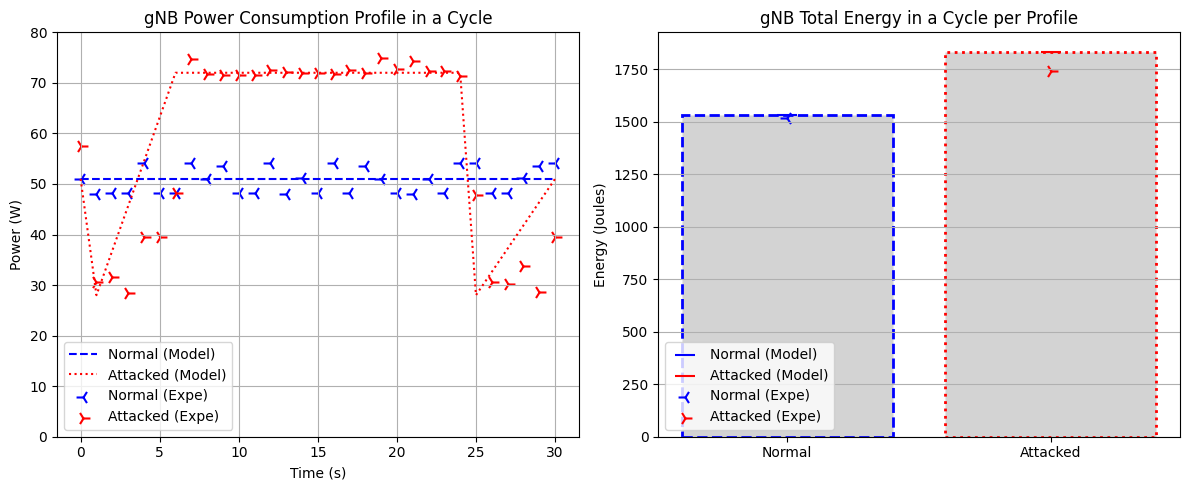

In [23]:
# --- Plot Experiment 3 ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left plot: Power consumption profiles
axs[0].plot(t1_model, p1_model, label="Normal (Model)", color='blue', linestyle='dashed')
axs[0].plot(t2_model, p2_model, label="Attacked (Model)", color='red', linestyle='dotted')

axs[0].scatter(t1, p1_exp, label="Normal (Expe)", color='blue', marker='3', s=100)
axs[0].scatter(t2, p2_exp, label="Attacked (Expe)", color='red', marker='4', s=100)

axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Power (W)")
axs[0].set_ylim(0, 80)
axs[0].set_title("gNB Power Consumption Profile in a Cycle")
axs[0].legend()
axs[0].grid(True)

# Right plot: Energy bar comparison
bars = axs[1].bar(["Normal", "Attacked"],
                  [energy1_model, energy2_model],
                  color='#D3D3D3',
                  edgecolor=['blue', 'red'],
                  linewidth=2)

linestyles = ['dashed', 'dotted']
for i, bar in enumerate(bars):
    bar.set_linestyle(linestyles[i])

# Overlay modeled energy markers
axs[1].scatter(0, energy1_model, color='blue', marker='_', s=200, label="Normal (Model)")
axs[1].scatter(1, energy2_model, color='red', marker='_', s=200, label="Attacked (Model)")

# Overlay experimental energy markers
axs[1].scatter(0, energy1_exp, color='blue', marker='3', s=100, label="Normal (Expe)")
axs[1].scatter(1, energy2_exp, color='red', marker='4', s=100, label="Attacked (Expe)")

axs[1].set_ylabel("Energy (Joules)")
axs[1].set_title("gNB Total Energy in a Cycle per Profile")
axs[1].grid(True, axis='y')
axs[1].legend()

plt.tight_layout()
plt.show()
